In [1]:
%matplotlib inline

from matplotlib import style
style.use('fivethirtyeight')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc
from scipy import stats

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Test connection
#engine.execute('SELECT (*) FROM Station').fetchall()
#engine.execute('SELECT COUNT(*) FROM Measurement').fetchall()

# Exploratory Climate Analysis

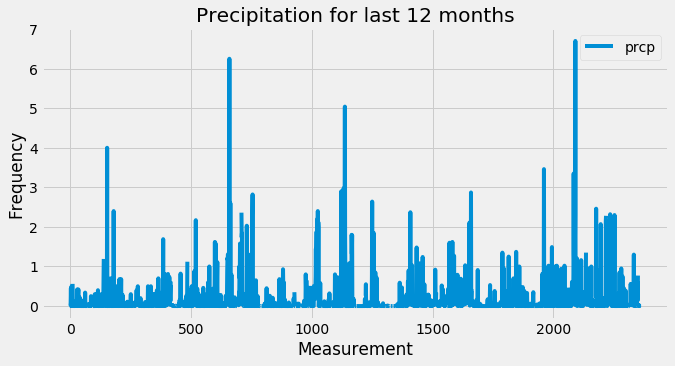

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
lastdate = session.query(func.max(Measurement.date)).scalar()

oneyearago = dt.date(int(lastdate[0:4]),int(lastdate[6:7]),int(lastdate[9:10])) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= oneyearago).order_by(Measurement.date.desc())

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data)
precipitation_df.set_index('date').head()

# Sort the dataframe by date
# done already in query

# Use Pandas Plotting with Matplotlib to plot the data
chart = precipitation_df.plot(figsize=(10,5))
chart.set_title("Precipitation for last 12 months")
chart.set_ylabel("Frequency")
chart.set_xlabel("Measurement")
plt.show()

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2136.000000
mean,0.178516
std,0.457667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [10]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
stations

9

In [11]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station,func.count(Measurement.station).label('Count')).group_by(Measurement.station).order_by(desc(func.count(Measurement.station)))
station_activity.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = station_activity.first()[0]
output = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
session.query(*output).filter(Measurement.station == most_active).all()


[(54.0, 85.0, 71.66378066378067)]

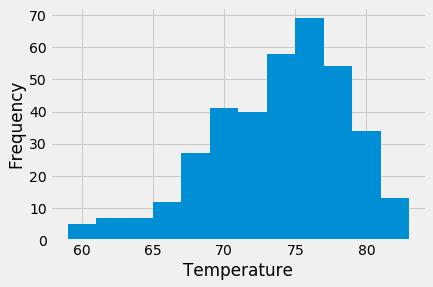

In [13]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_lastdate = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active).scalar()
lastdate

most_active_oneyearago = dt.date(int(most_active_lastdate[0:4]),int(most_active_lastdate[6:7]),int(most_active_lastdate[9:10])) - dt.timedelta(days=365)
most_active_oneyearago

most_active_temperatures = session.query(Measurement.tobs).filter(Measurement.station == most_active).filter(Measurement.date >= most_active_oneyearago).order_by(Measurement.date.desc()).all()
active_temperatures_df = pd.DataFrame(most_active_temperatures)

plt.hist(active_temperatures_df.tobs,bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [14]:
#Analysis 1: Identify the average temperature in June and December

june_avg = session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).filter(func.strftime('%m',Measurement.date) == '06').all()
dec_avg = session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).filter(func.strftime('%m',Measurement.date) == '12').all()
dec_avg

stats.ttest_ind(june_avg, dec_avg, equal_var=False)

#Pvalue < 0.001 indicates that t-statistic of 4.6... is 'statistically highly significant'. i.e. June is warmer than December

Ttest_indResult(statistic=array([4.61586542]), pvalue=array([0.00036573]))

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#choosing trip date of 2020-08-01 -> 2020-09-01, data will be a few years old so previous year = 2017
trip_temps = calc_temps('2017-08-01','2017-09-01')
trip_temps


[(70.0, 78.82417582417582, 85.0)]

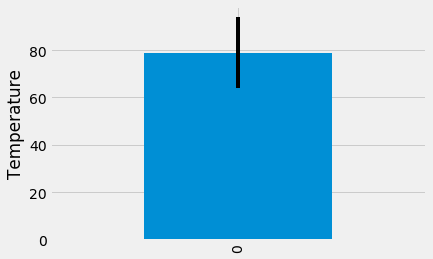

In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_temps, columns=['Min','Avg','Max'])
trip_df = trip_df[['Min','Max','Avg']]

average_temp = trip_df['Avg']
average_temp.plot(kind='bar', yerr=(trip_df.iloc[0]['Max'] - trip_df.iloc[0]['Min']))
plt.ylabel('Temperature')
plt.show()

In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def rainfall(start_date,end_date):
    output = [Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation, Measurement.prcp]
    
    return session.query(*output).filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

result_df = pd.DataFrame(rainfall('2017-08-01','2017-09-01')).rename({'station':'Station','name':'Name','latitude':'Latitude','longitude':'Longitude','elevation':'Elevation','prcp':'Precipitation'},axis=1)
result_df

,Station,Name,Latitude,Longitude,Elevation,Precipitation
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.12
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.00
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,NaN


In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [20]:
# calculate the daily normals for your trip

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings
dates = pd.date_range(dt.date(2017,8,1),dt.date(2017,9,1)).strftime('%m-%d')
dates

# push each tuple of calculations into a list called `normals`
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for my_date in dates:
    normals.append(*daily_normals(my_date))

In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['Min','Avg','Max'])[['Min','Max','Avg']]
normals_df['Date'] = dates
normals_df.set_index('Date')

,Min,Max,Avg
Date,,,
08-01,67.0,83.0,75.540000
08-02,68.0,84.0,75.603774
08-03,70.0,85.0,76.611111
08-04,69.0,84.0,76.711538
08-05,69.0,82.0,76.148148
08-06,67.0,83.0,76.250000
08-07,71.0,83.0,77.156863
08-08,68.0,83.0,76.557692
08-09,69.0,81.0,75.980392


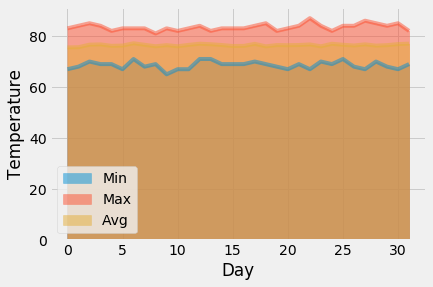

In [22]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False)
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.show()